# BM3D Experiment

In [1]:
import os

import bm3d
import numpy as np
import matplotlib.pyplot as plt

from module.utils import display_4d_image, compute_psnr_ssim_from_4d_ndarray, plot_2d_data, save_denoised_dicom

import h5py
import pydicom

from tqdm.notebook import tqdm

from skimage.metrics import peak_signal_noise_ratio as cal_psnr
from skimage.metrics import structural_similarity as cal_ssim

from scipy.ndimage import uniform_filter

In [2]:
# define Anscombe transform
def anscombe(x):
    return 2 * np.sqrt(x + 3 / 8)

# define inverse anscombe transform
def inv_anscombe(y):
    return (y / 2) ** 2 - 3 / 8

# estimate transformed noise std by sliding window
def estimate_noise(image, window_size=7):
    # calculate local mean
    local_mean = uniform_filter(image, window_size)
    
    # calculate local variance
    local_var = uniform_filter(image**2, window_size) - local_mean**2
    
    # calcualte average std 
    noise_std = np.sqrt(np.clip(local_var, 0, np.inf)).mean()
    
    return noise_std

def plot_histogram(image_4d):
    flattened_values = image_4d.flatten()

    plt.hist(flattened_values, bins=256, density=True, color='blue', alpha=0.7, rwidth=0.85)
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.title('Histogram of 4D Image')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

## Load dataset

Noisy data...float64 (shape:(24, 71, 192, 192); range:[0.0,1.0]; mean:0.503068948755769); std:0.02155238472359199
b'{"mean": 201.12048776036573, "std": 1412.4139804758772, "min": -23.34168377224119, "max": 23.05689405684542}'


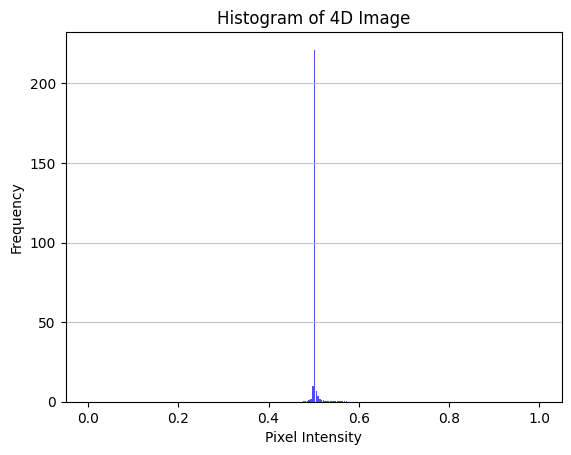

In [3]:
with h5py.File('./dataset/preprocessed/PT_20p 150_120 OSEM_real.h5', 'r') as f:
    noisy_data = f['dataset'][...]
    restore_info = f['restore_info'][...]
    
print(f"Noisy data...{noisy_data.dtype} (shape:{noisy_data.shape}; range:[{np.min(noisy_data)},{np.max(noisy_data)}]; mean:{np.mean(noisy_data)}); std:{np.std(noisy_data)}")

print(restore_info)

plot_histogram(noisy_data)

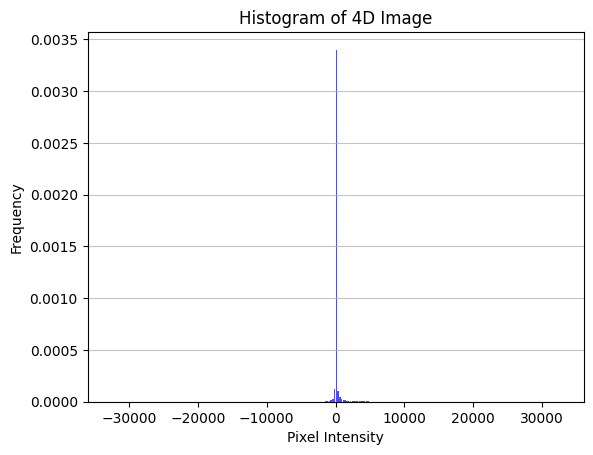

Text(0.5, 1.0, 'denormalied noisy image')

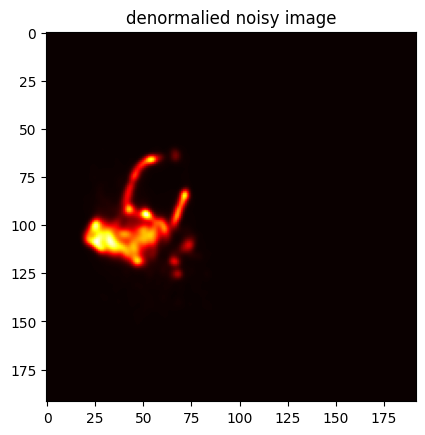

In [4]:
# display denormalied noisy data
max_val = 23.05689405684542
min_val = -23.34168377224119
mean_val = 201.12048776036573
std_val = 1412.4139804758772


denormalized_noisy_data = noisy_data * (max_val - min_val) + min_val
denormalized_noisy_data = denormalized_noisy_data * std_val + mean_val

denormalized_noisy_data = np.clip(denormalized_noisy_data, np.iinfo(np.int16).min, np.iinfo(np.int16).max).astype(np.int16)

#
plot_histogram(denormalized_noisy_data)

#
plt.imshow(denormalized_noisy_data[11, 38], cmap='hot')
plt.title("denormalied noisy image")

## Example denoising

```mermaid

flowchart TD
    A[noisy image] -->|anscombe transform| B(transformed image)
    B --> |estimator| C(noise std)
    C --> |denoise on noisy image| --> D{BM3D} 
    D --> F(denoised image)
    
```

noisy_image: dtype:float64 range(0.49998474074526206,1.0) mean:0.5085818269687141 std:0.04376361677055638
noise_std: 0.004361301326970563
denoised_image: dtype:float64 range(0.4999994933605194,1.0001341104507446) mean:0.5085745106108435 std:0.04375269714799276
origin.vs.inverse denoised: 
 PSNR:67.26778477103042; SSIM:0.9998576268087137


Text(0.5, 1.0, 'denoised')

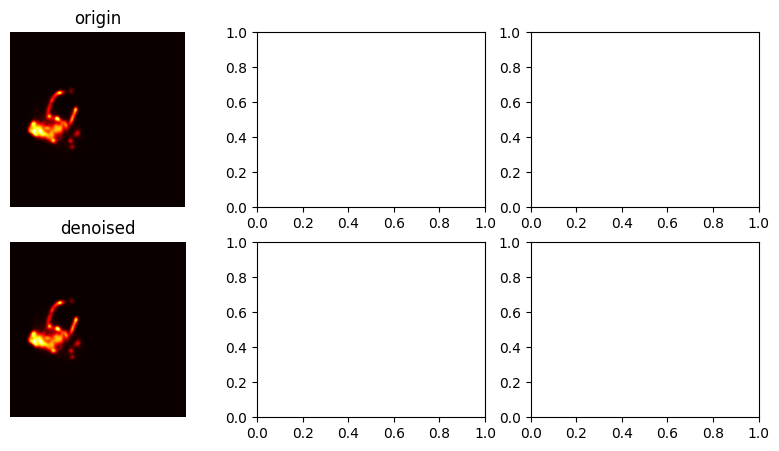

In [5]:
## example poission/real noise denoising

noisy_image = noisy_data[11, 38]
print(f"noisy_image: dtype:{noisy_image.dtype} range({np.min(noisy_image)},{np.max(noisy_image)}) mean:{np.mean(noisy_image)} std:{np.std(noisy_image)}")


# apply anscombe transform
transformed_noisy_image = anscombe(noisy_image)


# estimate noise level of transformed image 
noise_std = estimate_noise(transformed_noisy_image)
print(f"noise_std: {noise_std}")

# denoised with BM3D
# denoised_image = bm3d.bm3d(transformed_noisy_image, noise_std)
denoised_image = bm3d.bm3d(noisy_image, noise_std)
print(f"denoised_image: dtype:{denoised_image.dtype} range({np.min(denoised_image)},{np.max(denoised_image)}) mean:{np.mean(denoised_image)} std:{np.std(denoised_image)}")


# inversed transform the denoised image 
#inv_denoised_image = inv_anscombe(denoised_image)


# calcualte PSNR SSIM
data_range_noisy = np.max(noisy_image) - np.min(noisy_image)
data_range_denoised = np.max(denoised_image) - np.min(denoised_image)
data_range = max(data_range_noisy, data_range_denoised)

#
#print(f"transformed vs. denoised: \n PSNR:{cal_psnr(transformed_noisy_image, denoised_image, data_range=data_range)}; SSIM:{cal_ssim(transformed_noisy_image, denoised_image, data_range=data_range)}")
#print(f"origin.vs.inverse denoised: \n PSNR:{cal_psnr(inv_denoised_image, noisy_image, data_range=data_range)}; SSIM:{cal_ssim(inv_denoised_image, noisy_image, data_range=data_range)}")
print(f"origin.vs.inverse denoised: \n PSNR:{cal_psnr(denoised_image, noisy_image, data_range=data_range)}; SSIM:{cal_ssim(denoised_image, noisy_image, data_range=data_range)}")


# display image
fig, axes = plt.subplots(2, 3, figsize=(10, 5))
ax = axes.ravel()

ax[0].set_axis_off()
ax[0].imshow(noisy_image, cmap='hot')
ax[0].set_title("origin")

# ax[1].set_axis_off()
# ax[1].imshow(transformed_noisy_image, cmap='hot')
# ax[1].set_title("anscombe")

# ax[2].set_axis_off()
# ax[2].imshow(noisy_image - transformed_noisy_image, cmap='hot')
# ax[2].set_title("diff")

                
ax[3].set_axis_off()
ax[3].imshow(denoised_image, cmap='hot')
ax[3].set_title("denoised")

# ax[4].set_axis_off()
# ax[4].imshow(inv_denoised_image, cmap='hot')
# ax[4].set_title("inverse denoised")

# ax[5].set_axis_off()
# ax[5].imshow(inv_denoised_image - denoised_image, cmap='hot')
# ax[5].set_title("diff")

## Process denoising

In [6]:
%time 


# 33min on Ryzen 5600H

# denoised data array 
denoised_data = np.empty_like(noisy_data)

# estimate noise level 
#transformed_data = anscombe(noisy_data)
#noise_std = estimate_noise(transformed_data)

total_iterations = noisy_data.shape[0] * noisy_data.shape[1]
with tqdm(total=total_iterations, desc='Processing') as pbar:
    for i in range(noisy_data.shape[0]):
        for j in range(noisy_data.shape[1]):
            sub_image = noisy_data[i, j, :, :]
            # apply anscombe transform 
            transformed_sub_image = anscombe(sub_image)
            # estimate noise std of transformed noisy image
            noise_std = estimate_noise(transformed_sub_image)
            #print(noise_std)
            #denoise with BM3D with estimate noise std
            denoised_sub_image = bm3d.bm3d(sub_image, noise_std)
            # 
            denoised_data[i, j, :, :] = denoised_sub_image
            # update tqdm bar 
            pbar.update(1)

#
print(f"denoised_data; {denoised_data.dtype} shape:{denoised_data.shape} range:({np.min(denoised_data)},{np.max(denoised_data)}); mean:{np.mean(denoised_data)} std:{np.std(denoised_data)}")

CPU times: total: 0 ns
Wall time: 0 ns


Processing:   0%|          | 0/1704 [00:00<?, ?it/s]

denoised_data; float64 shape:(24, 71, 192, 192) range:(-0.001274167443625629,1.0023720264434814); mean:0.5030652246031401 std:0.021421610177803033


## Evaluation

Calculate PSNR, SSIM

PSNR(avg): 76.949554880675; SSIM(avg): 0.9978541499896252
argmax: (0, 7)
argmin: (4, 1)


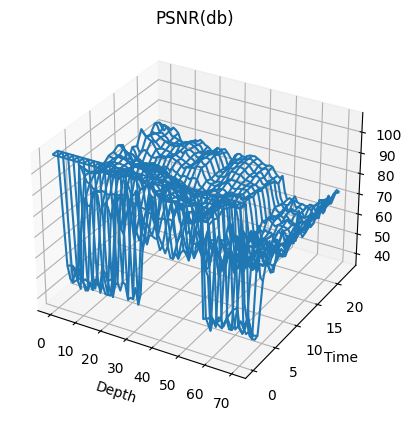

argmax: (0, 51)
argmin: (4, 1)


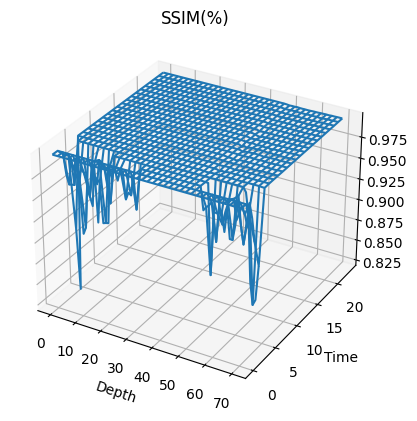

In [7]:
# calcualte PSNR, SSIM between denoised data and noisy data
data_range_noisy = np.max(noisy_image) - np.min(noisy_image)
data_range_denoised = np.max(denoised_data) - np.min(denoised_data)
data_range = max(data_range_noisy, data_range_denoised)

#
all_psnr, all_ssim = compute_psnr_ssim_from_4d_ndarray(denoised_data, noisy_data, data_range)

#
print(f"PSNR(avg): {np.mean(all_psnr)}; SSIM(avg): {np.mean(all_ssim)}")

plot_2d_data(all_psnr, "PSNR(db)")
plot_2d_data(all_ssim, "SSIM(%)")

## Save denormalized denoised image into int16 DICOM file

denormalized_denoised_data: dtype:int16 range(-32768,32767) mean:200.67243335865163 std:1403.793143439745


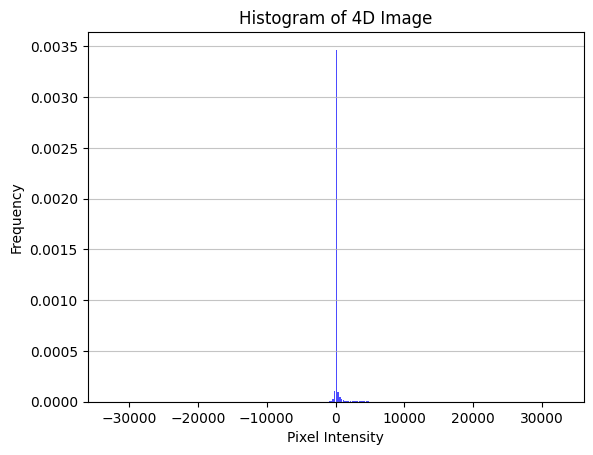

Text(0.5, 1.0, 'denoised')

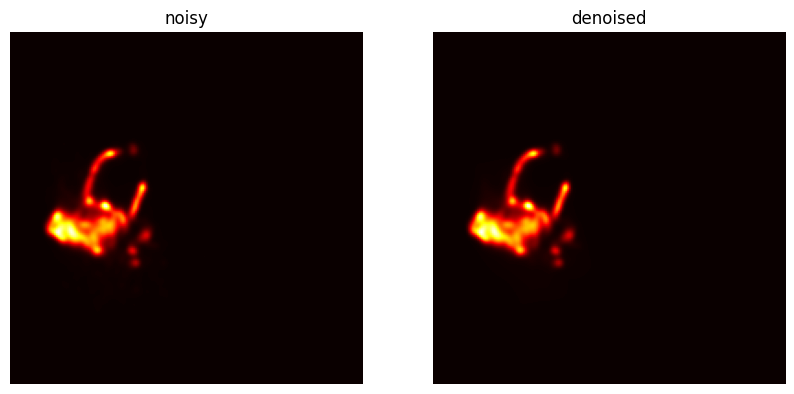

In [8]:
# denormalzied denoised data
mean_val = 201.12048776036573
std_val = 1412.4139804758772
max_val = 23.05689405684542
min_val = -23.34168377224119


denormalized_denoised_data = denoised_data * (max_val - min_val) + min_val
denormalized_denoised_data = denormalized_denoised_data * std_val + mean_val

denormalized_denoised_data = np.clip(denormalized_denoised_data, np.iinfo(np.int16).min, np.iinfo(np.int16).max).astype(np.int16)

print(f"denormalized_denoised_data: dtype:{denormalized_denoised_data.dtype} range({np.min(denormalized_denoised_data)},{np.max(denormalized_denoised_data)}) mean:{np.mean(denormalized_denoised_data)} std:{np.std(denormalized_denoised_data)}")

#
plot_histogram(denormalized_denoised_data)

# display_4d_image(denormalized_denoised_data)
#plt.imshow(denormalized_denoised_data[11, 38], cmap='hot')

#
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ax = axes.ravel()

ax[0].set_axis_off()
ax[0].imshow(noisy_data[11, 38], cmap='hot')
ax[0].set_title("noisy")

ax[1].set_axis_off()
ax[1].imshow(denormalized_denoised_data[11, 38], cmap='hot')
ax[1].set_title("denoised")


In [9]:
origin_dicom_folder = './dataset/TracPETperf-D2-PhantomExperiments2/PT_20p 150_120 OSEM'

output_folder = './dataset/denoised/BM3D/PT_20p 150_120 OSEM_real'

save_denoised_dicom(origin_dicom_folder, denormalized_denoised_data, output_folder)

Processing time points:   0%|          | 0/24 [00:00<?, ?it/s]

Saved 1704 denoised DICOM files.
